In [1]:
import torch
from torch import nn
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torch import optim
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import gc
import math
from sklearn.metrics import r2_score 

In [2]:
#Params
input_size=200
batch_size=512
nbr_epochs=20
data_split_ratio=0.8
chunksize = 1000000
lr = 0.0001
y_column = "30s"
files_x = ["data/x_Swedbank_A_200_p_channels.csv",]
files_y = ["data/y_Swedbank_A_200.csv",]

In [3]:
def splitData(xs, ys, trainRatio):
    t = round(len(xs)*trainRatio)
    
    train_data_x = torch.tensor(xs[:t].values, dtype=torch.float32)
    train_data_y = torch.tensor(ys[:t].values, dtype=torch.float32)
    
    dev_data_x = torch.tensor(xs[t:].values, dtype=torch.float32)
    dev_data_y = torch.tensor(ys[t:].values, dtype=torch.float32)
    
    return TensorDataset(train_data_x, train_data_y), TensorDataset(dev_data_x, dev_data_y)

In [4]:
#compute_unit = "cuda:0" if torch.cuda.is_available() else "cpu"
device = torch.device('cuda:0')
#device = torch.device("cpu")
#compute_unit = "cpu"

In [5]:
#dtype = torch.FloatTensor
dtype = torch.cuda.FloatTensor # Uncomment this to run on GPU

In [6]:
class StockModel(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        
        self.net = nn.Sequential(
            nn.Linear(input_size, 300).type(dtype),
            nn.LeakyReLU(),
            nn.Linear(300, 20).type(dtype),
            nn.LeakyReLU(),
            nn.Linear(20, 1).type(dtype),
            nn.LeakyReLU()
        )
        
        torch.nn.init.xavier_uniform_(self.net[0].weight)
        torch.nn.init.xavier_uniform_(self.net[2].weight)
        torch.nn.init.xavier_uniform_(self.net[4].weight)
        
        #self.fc1 = nn.Linear(input_size, 300).type(dtype)
        #self.fc1.weight.data.uniform_(-0.1, 0.1)
        #self.fc2 = nn.Linear(300, 20).type(dtype)
        #self.fc2.weight.data.uniform_(-0.1, 0.1)
        #self.fc3 = nn.Linear(20, 1).type(dtype)
        #self.fc3.weight.data.uniform_(-0.1, 0.1)
        #self.fc4 = nn.Linear(1, 20).type(dtype)
        #self.fc4.weight.data.uniform_(-0.1, 0.1)
        #self.fc5 = nn.Linear(20, 1).type(dtype)
        #elf.fc5.weight.data.uniform_(-0.1, 0.1)
        #self.fc6 = nn.Linear(100, 20).type(dtype)
        #self.fc6.weight.data.uniform_(-0.1, 0.1)
        #self.fc7 = nn.Linear(20, 1).type(dtype)
        #self.fc7.weight.data.uniform_(-0.1, 0.1)
        
        #self.bn1 = nn.BatchNorm1d(num_features=input_size, track_running_stats=True)
        #self.sig = nn.Sigmoid()
        
        #self.drop_layer = nn.Dropout(p=0.010)
        #self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = self.net(x)
        return x

In [7]:
def evaluate_model(data, model, loss_fn):
    losses = []
    ys = []
    predictions = []
    model.eval()
    with torch.no_grad():
        for x, y in data:
            y = y.type(dtype)
            x = x.type(dtype)
            pred = model(x).squeeze()
            loss = loss_fn(pred, y)
            losses.append(loss.item())
            ys.extend(y.tolist())
            predictions.extend(pred.tolist())
        avg_loss = sum(losses)/len(losses)    
        
    r2 = r2_score(ys, predictions)
    return avg_loss, predictions, r2

In [8]:
def train_model(model, train_data_loader, dev_data_loader, loss_fn, optimizer, epochrange, batchsize):
    for epoch in range(epochrange):
        losses = []
        n_correct = 0
        model.train()
        for x, y in train_data_loader:
            y = y.type(dtype)
            x = x.type(dtype)
            pred = model(x).squeeze()
            loss = loss_fn(pred, y)
            losses.append(loss.item())
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()    

        # Compute accuracy and loss in the entire training set
        train_avg_loss = sum(losses)/len(losses)    
        
        dev_avg_loss,_,r2 = evaluate_model(dev_data_loader, model, loss_fn)
        
        # Display metrics
        display_str = 'Epoch {} '
        display_str += '\tLoss: {:.6f} '
        display_str += '\tLoss (val): {:.6f}'
        display_str += '\tR^2 score: {:.4f}'
        print(display_str.format(epoch, train_avg_loss, dev_avg_loss, r2))

In [9]:
def train_chunk(model, loss_fn, optimizer, nbr_epochs, x_data, y_data, data_split_ratio, batch_size):
    train_data, dev_data = splitData(x_data, y_data, data_split_ratio)
    train_data_loader = DataLoader(train_data, batch_size=batch_size, drop_last=True)
    dev_data_loader = DataLoader(dev_data, batch_size=batch_size, drop_last=True)
    train_model(model, train_data_loader, dev_data_loader, loss_fn, optimizer, nbr_epochs, batch_size)

In [10]:
#Start training
model = StockModel(input_size)
loss_fn = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=lr, eps=0.001)
model = model.to(device)
test_data_x = pd.DataFrame()
test_data_y = pd.DataFrame()
for i in range(len(files_x)):
    print("Current file: " + files_x[i])
    total_rows = sum(1 for row in open(files_x[i], 'r'))
    number_of_loops = int(total_rows/chunksize)
    print("Number of chunks: " + str(number_of_loops))
    current_loop = 0
    with pd.read_csv(files_x[i], sep=";", dtype="float32", usecols = [j for j in range(input_size)], chunksize=chunksize) as reader_x,\
    pd.read_csv(files_y[i], sep=";", dtype="float32", converters = {'ts': int}, chunksize=chunksize) as reader_y:
        for chunk_x, chunk_y in zip(reader_x, reader_y):
            print("Progress: " + "{:.2f}".format(100 * current_loop/number_of_loops) + "%")
            x_data = chunk_x
            y_data = chunk_y
            if(current_loop < data_split_ratio * number_of_loops):
                y_data = y_data[y_column]
                train_chunk(model, loss_fn, optimizer, nbr_epochs, x_data, y_data, data_split_ratio, batch_size)
            else:
                print("Append test data")
                test_data_x = test_data_x.append(x_data)
                test_data_y = test_data_y.append(y_data)
            current_loop+=1

test_data_x = torch.tensor(test_data_x.values, dtype=torch.float32)
test_data_y= torch.tensor(test_data_y[y_column].values, dtype=torch.float32)
test_data = TensorDataset(test_data_x, test_data_y)

Current file: data/x_Swedbank_A_200_p_channels.csv
Number of chunks: 4


/home/oscar/anaconda3/envs/gtx/lib/python3.7/site-packages/ipykernel_launcher.py:16: ParserWarning: Both a converter and dtype were specified for column ts - only the converter will be used
  app.launch_new_instance()


Progress: 0.00%
Epoch 0 	Loss: 2.812006 	Loss (val): 0.029132	R^2 score: 0.9730
Epoch 1 	Loss: 0.846035 	Loss (val): 0.117212	R^2 score: 0.8914
Epoch 2 	Loss: 0.958436 	Loss (val): 0.091848	R^2 score: 0.9149
Epoch 3 	Loss: 0.924882 	Loss (val): 0.077659	R^2 score: 0.9280
Epoch 4 	Loss: 0.899632 	Loss (val): 0.065667	R^2 score: 0.9392
Epoch 5 	Loss: 0.881758 	Loss (val): 0.056795	R^2 score: 0.9474
Epoch 6 	Loss: 0.846922 	Loss (val): 0.066320	R^2 score: 0.9385
Epoch 7 	Loss: 0.806927 	Loss (val): 0.068302	R^2 score: 0.9367
Epoch 8 	Loss: 0.780489 	Loss (val): 0.079417	R^2 score: 0.9264
Epoch 9 	Loss: 0.754595 	Loss (val): 0.099290	R^2 score: 0.9080
Epoch 10 	Loss: 0.728765 	Loss (val): 0.111208	R^2 score: 0.8970
Epoch 11 	Loss: 0.704757 	Loss (val): 0.112344	R^2 score: 0.8959
Epoch 12 	Loss: 0.681956 	Loss (val): 0.102652	R^2 score: 0.9049
Epoch 13 	Loss: 0.661646 	Loss (val): 0.080242	R^2 score: 0.9256
Epoch 14 	Loss: 0.642221 	Loss (val): 0.053105	R^2 score: 0.9508
Epoch 15 	Loss: 0.6

/home/oscar/anaconda3/envs/gtx/lib/python3.7/site-packages/ipykernel_launcher.py:16: ParserWarning: Both a converter and dtype were specified for column ts - only the converter will be used
  app.launch_new_instance()


Progress: 25.00%
Epoch 0 	Loss: 0.783712 	Loss (val): 0.132010	R^2 score: 0.8969
Epoch 1 	Loss: 0.691320 	Loss (val): 0.258009	R^2 score: 0.7986
Epoch 2 	Loss: 0.674018 	Loss (val): 0.417208	R^2 score: 0.6743
Epoch 3 	Loss: 0.653762 	Loss (val): 0.457774	R^2 score: 0.6426
Epoch 4 	Loss: 0.633542 	Loss (val): 0.457902	R^2 score: 0.6425
Epoch 5 	Loss: 0.810285 	Loss (val): 0.259271	R^2 score: 0.7976
Epoch 6 	Loss: 0.559896 	Loss (val): 0.253919	R^2 score: 0.8018
Epoch 7 	Loss: 0.567898 	Loss (val): 0.139036	R^2 score: 0.8915
Epoch 8 	Loss: 0.551088 	Loss (val): 0.159816	R^2 score: 0.8752
Epoch 9 	Loss: 0.553421 	Loss (val): 0.309452	R^2 score: 0.7584
Epoch 10 	Loss: 0.536817 	Loss (val): 0.235048	R^2 score: 0.8165
Epoch 11 	Loss: 0.519983 	Loss (val): 0.208879	R^2 score: 0.8369
Epoch 12 	Loss: 0.505656 	Loss (val): 0.197732	R^2 score: 0.8456
Epoch 13 	Loss: 0.503662 	Loss (val): 0.193188	R^2 score: 0.8492
Epoch 14 	Loss: 0.485318 	Loss (val): 0.184388	R^2 score: 0.8561
Epoch 15 	Loss: 0.

/home/oscar/anaconda3/envs/gtx/lib/python3.7/site-packages/ipykernel_launcher.py:16: ParserWarning: Both a converter and dtype were specified for column ts - only the converter will be used
  app.launch_new_instance()


Progress: 50.00%
Epoch 0 	Loss: 0.528583 	Loss (val): 0.079285	R^2 score: 0.9918
Epoch 1 	Loss: 0.515962 	Loss (val): 0.080792	R^2 score: 0.9916
Epoch 2 	Loss: 0.497233 	Loss (val): 0.086987	R^2 score: 0.9910
Epoch 3 	Loss: 0.480522 	Loss (val): 0.099986	R^2 score: 0.9896
Epoch 4 	Loss: 0.467050 	Loss (val): 0.122053	R^2 score: 0.9873
Epoch 5 	Loss: 0.454976 	Loss (val): 0.159593	R^2 score: 0.9835
Epoch 6 	Loss: 0.443036 	Loss (val): 0.201961	R^2 score: 0.9791
Epoch 7 	Loss: 0.432059 	Loss (val): 0.230549	R^2 score: 0.9761
Epoch 8 	Loss: 0.420978 	Loss (val): 0.233027	R^2 score: 0.9758
Epoch 9 	Loss: 0.409009 	Loss (val): 0.207653	R^2 score: 0.9785
Epoch 10 	Loss: 0.422152 	Loss (val): 0.168894	R^2 score: 0.9825
Epoch 11 	Loss: 0.399348 	Loss (val): 0.102657	R^2 score: 0.9894
Epoch 12 	Loss: 0.401049 	Loss (val): 0.080745	R^2 score: 0.9916
Epoch 13 	Loss: 0.408810 	Loss (val): 0.100822	R^2 score: 0.9895
Epoch 14 	Loss: 0.413226 	Loss (val): 0.191228	R^2 score: 0.9802
Epoch 15 	Loss: 0.

/home/oscar/anaconda3/envs/gtx/lib/python3.7/site-packages/ipykernel_launcher.py:16: ParserWarning: Both a converter and dtype were specified for column ts - only the converter will be used
  app.launch_new_instance()


Progress: 75.00%
Epoch 0 	Loss: 0.261510 	Loss (val): 0.597490	R^2 score: 0.9424
Epoch 1 	Loss: 0.259831 	Loss (val): 0.641423	R^2 score: 0.9381
Epoch 2 	Loss: 0.228424 	Loss (val): 0.732898	R^2 score: 0.9293
Epoch 3 	Loss: 0.228207 	Loss (val): 0.767733	R^2 score: 0.9259
Epoch 4 	Loss: 0.218924 	Loss (val): 0.799931	R^2 score: 0.9228
Epoch 5 	Loss: 0.242852 	Loss (val): 0.691305	R^2 score: 0.9333
Epoch 6 	Loss: 0.207690 	Loss (val): 0.760541	R^2 score: 0.9266
Epoch 7 	Loss: 0.219980 	Loss (val): 0.666277	R^2 score: 0.9357
Epoch 8 	Loss: 0.199944 	Loss (val): 0.562213	R^2 score: 0.9458
Epoch 9 	Loss: 0.195831 	Loss (val): 0.511999	R^2 score: 0.9506
Epoch 10 	Loss: 0.192957 	Loss (val): 0.439714	R^2 score: 0.9576
Epoch 11 	Loss: 0.189901 	Loss (val): 0.372274	R^2 score: 0.9641
Epoch 12 	Loss: 0.186670 	Loss (val): 0.311043	R^2 score: 0.9700
Epoch 13 	Loss: 0.182335 	Loss (val): 0.276456	R^2 score: 0.9733
Epoch 14 	Loss: 0.202089 	Loss (val): 0.723671	R^2 score: 0.9302
Epoch 15 	Loss: 0.

/home/oscar/anaconda3/envs/gtx/lib/python3.7/site-packages/ipykernel_launcher.py:16: ParserWarning: Both a converter and dtype were specified for column ts - only the converter will be used
  app.launch_new_instance()


In [11]:
test_data_loader = DataLoader(test_data, batch_size=2)
loss, preds, r2 = evaluate_model(test_data_loader, model, loss_fn)
print("Test loss: " + str(loss))
print("Test R^2: " + str(r2))

Test loss: 0.25885943271566986
Test R^2: 0.5545942490324707


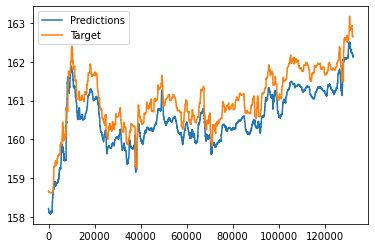

In [12]:
plt.plot(list(range(len(preds))), preds, label="Predictions")
plt.plot(list(range(len(test_data_y))), test_data_y.tolist(), label="Target")
axes = plt.gca()
#axes.set_ylim([146,148])
plt.legend()
#axes.set_xlim([260000,261200])
#axes.set_xlim([100000,120000])
#axes.set_xlim([140000,160000])
#xes.set_xlim([540000,560000])
#axes.set_xlim([610000,660000])
#axes.set_xlim([660000,660100])
#axes.set_ylim([157,158])
plt.show()